# **Predict Price**

## Objectives

* Fit and evaluate a regression model to predict the sale price of houses in Ames, Iowa.

## Inputs

* outputs/datasets/collection/HousePriceRecords.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* Feature Importance Plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing'

---

# Load Data

Load the house price records file

In [6]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# ML Pipeline

The pipeline will be built based on the analyses and conclusions from the Data Cleaning and Feature Engineering notebooks.
The below is an adaptation of the pipeline used in the regressor section of the Code Institution Churnometer walkthrough project.

In [7]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import (MeanMedianImputer,CategoricalImputer)

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineRegressor(model):
    pipeline_base = Pipeline([

        # Data Cleaning
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['EnclosedPorch','WoodDeckSF','BedroomAbvGr','2ndFlrSF','GarageYrBlt','MasVnrArea'])),

        ("MeanImputation", MeanMedianImputer(imputation_method='mean', variables=['LotFrontage'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='frequent', variables=['GarageFinish','BsmtFinType1'])),

        # Feature Engineering
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['LotArea', 'LotFrontage'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['2ndFlrSF', 'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


The custom class before assists with hyperparameter optimisation, and has been taken from the Code Institute walkthough project for the Churnometer.

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineRegressor(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

---

# Split Train and Test Sets

The data set will be split into the train and test sets, with a standard 20% in the test set.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


---

# Grid Search CV - SKLearn

## Default Hyperparameters

The default hyperparameters will be used over the various parameters, in order to select the most suitable algorithm.

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Displaying results:

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.670015,0.795672,0.86355,0.072395
2,RandomForestRegressor,0.675986,0.790821,0.852225,0.064831
0,LinearRegression,0.726224,0.780655,0.837181,0.046081
5,GradientBoostingRegressor,0.575323,0.766273,0.841736,0.098117
4,AdaBoostRegressor,0.643592,0.73113,0.760623,0.044896
6,XGBRegressor,0.516199,0.717303,0.781729,0.101295
1,DecisionTreeRegressor,0.513775,0.626994,0.705022,0.072804


The Extra Trees Regressor algorithm has provided the best mean score at 0.795672.

## Determine Best Hyperparameters for Selected Algorithm

Define model and parameters for the search. Extra Trees Regressor has been selected, as it performed the best when reviewing each algorithm.
- Note: the parameters in the search are the suggested values from the Code Institute learning module "Scikit-Learn Unit 6: Cross Validation Search Part 2".

In [13]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            }
  }

Next, an extensive search is performed using GridSearch CV across the hyperparameters:

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Displaying the results:

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
29,ExtraTreesRegressor,0.736038,0.797237,0.850864,0.041766,15,1,50,150
5,ExtraTreesRegressor,0.736038,0.797208,0.85093,0.041757,None,1,50,150
27,ExtraTreesRegressor,0.73584,0.796959,0.849473,0.040962,15,1,50,100
3,ExtraTreesRegressor,0.73584,0.796927,0.849748,0.04099,None,1,50,100
2,ExtraTreesRegressor,0.674553,0.796923,0.865079,0.071665,None,1,2,150


The best mean score is 0.797237, a slight improvement on the 0.795672 achieved using the default hyperparameters. While only a slightly better mean score, these hyperparameters will be used. The next few boxes will pick out the best elements (model, hyperparameters) that have been identified, and the pipeline with these elements.

Picking the best model:

In [16]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

Picking the best hyperparameters for this model:

In [18]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 150}

The resulting pipeline based on these elements:

In [19]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('MedianImputation',
                 MeanMedianImputer(variables=['EnclosedPorch', 'WoodDeckSF',
                                              'BedroomAbvGr', '2ndFlrSF',
                                              'GarageYrBlt', 'MasVnrArea'])),
                ('MeanImputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage'])),
                ('CategoricalImputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish',
                                               'BsmtFinType1']...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'Over

---

# Evaluate on Train and Test Sets

The following custom functions will be used to assess the selected pipeline. This has been taken from the Code Institute Churnometer walkthough project.

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

These functions are applied to the selected pipeline to evaluate performance:

Model Evaluation 

* Train Set
R2 Score: 0.839
Mean Absolute Error: 20033.68
Mean Squared Error: 989884692.735
Root Mean Squared Error: 31462.433


* Test Set
R2 Score: 0.773
Mean Absolute Error: 21651.051
Mean Squared Error: 1565972235.031
Root Mean Squared Error: 39572.367




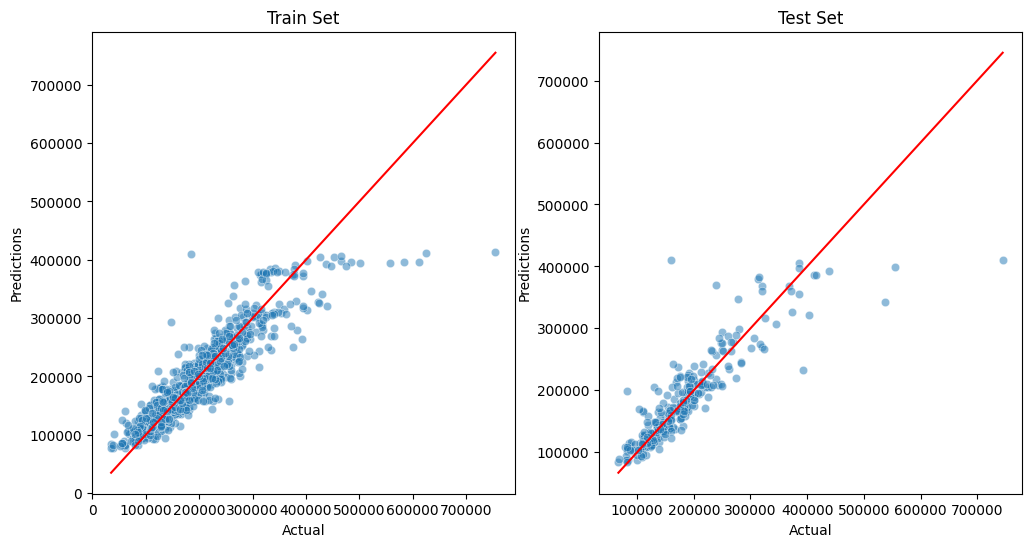

In [21]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

The R2 score on the train set is 0.839, and on the test set is 0.773. This indicates that the model is appropriate and can provide good quality predictions.

---

# Assess Feature Importance

The function below determines the most important features in the pipeline. This has been adapted from the Code Institute Churnometer walkthrough project.

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageArea', '1stFlrSF']


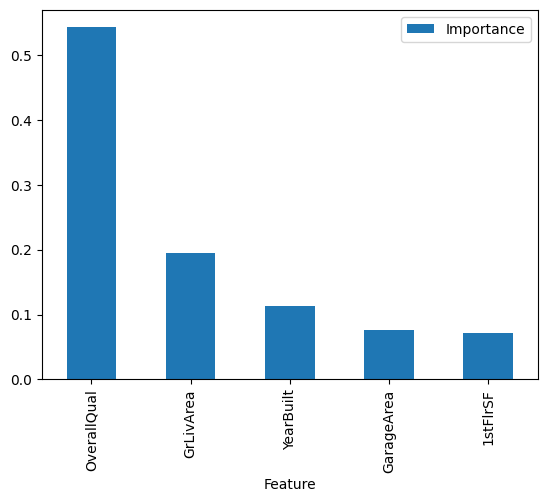

In [22]:
# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 7
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

---

# Rewrite ML Pipeline for Modelling

The five most important features will be used for training the model: OverallQual, GrLivArea, YearBuilt, GarageArea, 1stFlrSF.

Note that a number of the steps are applied to variables that we will not be using in the model:
- Median Imputation: none of these variables are in the five most important features.
- Mean Imputation: this variable is not in the five most important features.
- Categorical Imputation: none of these variables are in the five most important features.
- Ordinal Categorical Encoder: none of these variables are in the five most important features.
- Log Transformer: none of these variables are in the five most important features.
- Power Transformer: only GarageArea is included in the five most important features.

All steps that do not include these features have been removed from the pipeline below.


In addition, the Smart Correlated Selection and Feature Selection steps have been removed, as the relevant features have already been assessed.

In [23]:
def PipelineRegressor(model):
    pipeline_base = Pipeline([

        # Feature Engineering
        ("PowerTransformer", vt.PowerTransformer(variables=['GarageArea'])),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

The process above is repeated with this new version of the pipeline, to verify the scores are still suitable.

Splitting the test and train datasets:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


Reducing the datasets to only include the five best features:

In [27]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head()

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,1stFlrSF,GarageArea,GrLivArea,OverallQual,YearBuilt
618,1828,774,1828,9,2007
870,894,308,894,5,1962
92,964,432,964,5,1921
817,1689,857,1689,8,2002
302,1541,843,1541,7,2001


The selected model and associated hyperparameters:

In [28]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0)
}

params_search = {
    "ExtraTreesRegressor": {
        'model__max_depth': [15],
        'model__min_samples_leaf': [1],
        'model__min_samples_split': [50],
        'model__n_estimators': [150]}
}

Using the Grid Search again to check the R2 score:

In [29]:
search = HyperparameterOptimizationSearch(models=models_search,
                                          params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [30]:
(grid_search_summary, grid_search_pipelines) = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.76255,0.810239,0.850864,0.037792,15,1,50,150


The R2 score has improved marginally to 0.81 when using only the five best features.

The best model can now be built:

In [31]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

In [32]:
final_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
final_regressor_pipeline

Pipeline(steps=[('PowerTransformer',
                 PowerTransformer(variables=['GarageArea'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     n_estimators=150, random_state=0))])

Testing this pipeline's performance on the train and test sets:

Model Evaluation 

* Train Set
R2 Score: 0.839
Mean Absolute Error: 20033.68
Mean Squared Error: 989884692.735
Root Mean Squared Error: 31462.433


* Test Set
R2 Score: 0.773
Mean Absolute Error: 21651.051
Mean Squared Error: 1565972235.031
Root Mean Squared Error: 39572.367




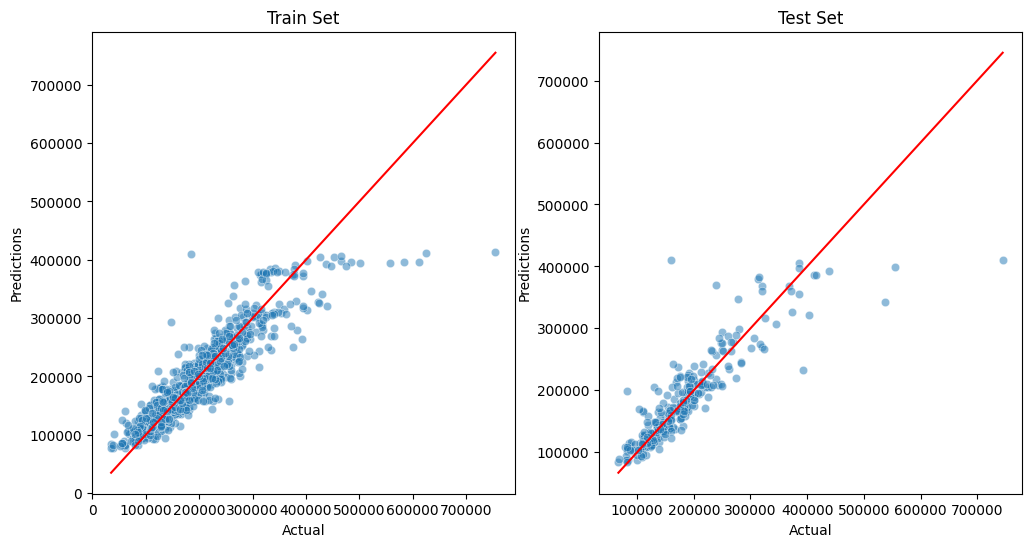

In [33]:
regression_performance(X_train, y_train, X_test, y_test, final_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, final_regressor_pipeline)

The R2 scores for the train and test sets are 0.839 and 0.773 respectively. This is in line with the test performed with all features in place. Therefore, reducing to the five best features is suitable for this pipeline, with an improvement in efficiency without any detriment to the performance.

---

# Push files to Repo

The following files will be generated and pushed to the repo:
- Train dataset
- Test dataset
- Modelling pipeline
- Features importance plot

In [34]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: Features and Target

In [35]:
X_train.head()

,1stFlrSF,GarageArea,GrLivArea,OverallQual,YearBuilt
618,1828,774,1828,9,2007
870,894,308,894,5,1962
92,964,432,964,5,1921
817,1689,857,1689,8,2002
302,1541,843,1541,7,2001


In [36]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [37]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [38]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features and Target

In [39]:
X_test.head()

,1stFlrSF,GarageArea,GrLivArea,OverallQual,YearBuilt
529,2515,484,2515,6,1957
491,958,240,1578,6,1941
459,979,352,1203,5,1950
279,1156,505,2022,7,1977
655,525,264,1092,6,1971


In [40]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [41]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [42]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling Pipeline

The ML pipeline for predicting sales prices of houses.

In [43]:
final_regressor_pipeline

Pipeline(steps=[('PowerTransformer',
                 PowerTransformer(variables=['GarageArea'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     n_estimators=150, random_state=0))])

In [45]:
joblib.dump(value=final_regressor_pipeline, filename=f"{file_path}/final_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_price/v1/final_regressor_pipeline.pkl']

## Features Importance Plot

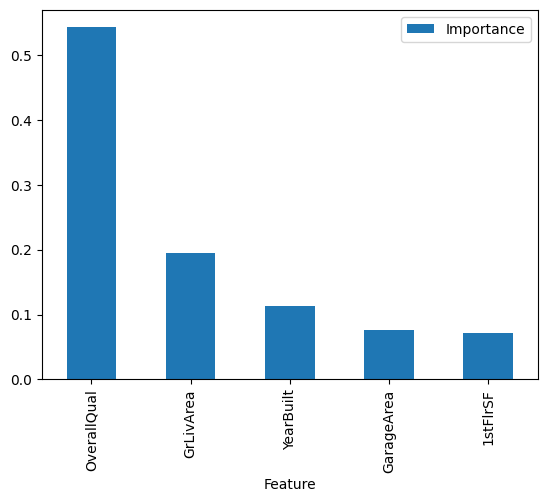

In [46]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

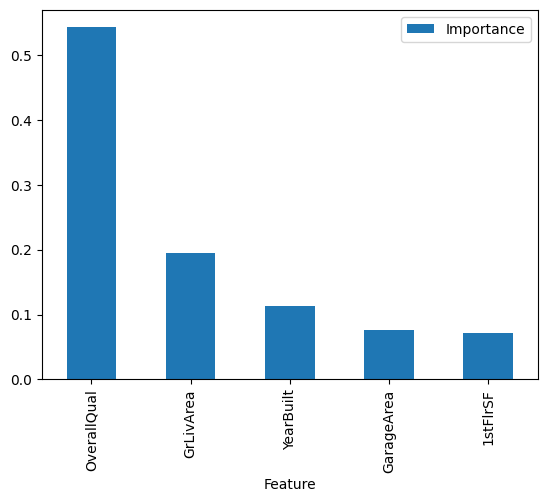

In [47]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')